In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 400)

In [2]:
df = pd.read_csv('../../data/corpus2.csv')

### Preprocessing

encoding labels

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
le = LabelEncoder()
df.emotion = le.fit_transform(df.emotion)

In [5]:
le.classes_

array(['Negative', 'Positive'], dtype=object)

In [6]:
df.head()

,tweet_text,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",1
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,1
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",1


feature and target split

In [7]:
X = df.tweet_text
y = df.emotion

In [8]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
sw = stopwords.words('english')
sw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
from nltk.tokenize import regexp_tokenize, RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [21]:
#update stop words to exclude the top 20 words in our distribution - this included words like 'sxsw' and product names 

sw.extend(['sxsw', 'ipad', 'mention', 'link', 'apple', 'google', 'iphone', 'store', 'quot', 'app', 'new', 'get', 'austin', 'android'])

In [22]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.25)

In [24]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [25]:
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, random_state = 1, test_size = 0.25)

### Visualizing common words from the tweets

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

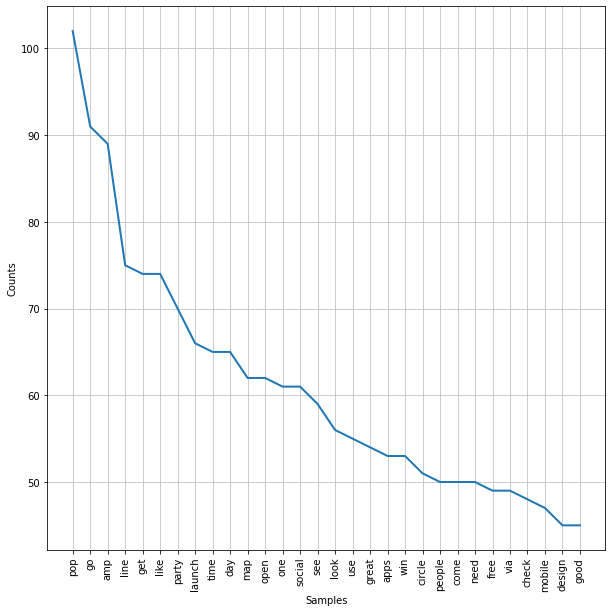

In [27]:
word_list = []
for doc in X_t:
    words = word_tokenize(doc)
    for word in words:
        word_list.append(word)
fdist = FreqDist(word_list)
plt.figure(figsize=(10,10))
fdist.plot(30);

In [28]:
print(list(fdist)[:14])

['pop', 'go', 'amp', 'line', 'get', 'like', 'party', 'launch', 'time', 'day', 'map', 'open', 'one', 'social']


In [29]:
my_string = ''
for doc in X_t:
    my_string += str(' ') + doc   

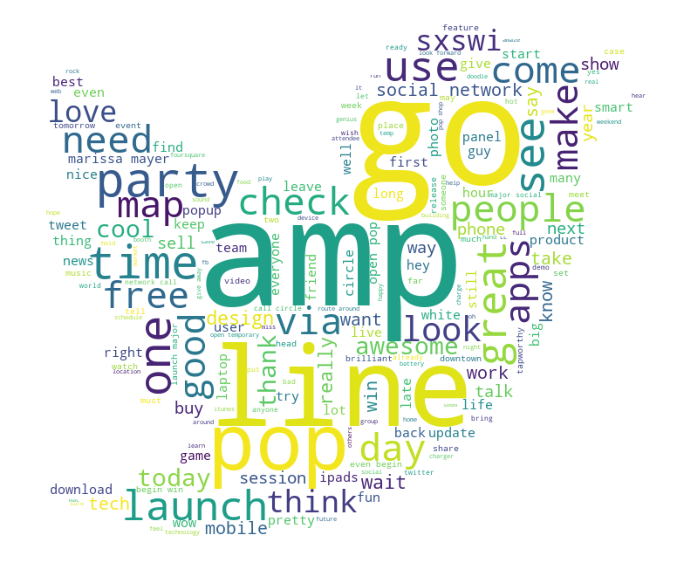

In [30]:
from PIL import Image
char_mask = np.array(Image.open('../../references/Twitter-Logo-Stencil.jpg'))
words_cloud = WordCloud(background_color='white', mask=char_mask).generate(my_string)
plt.figure(figsize=(12,12))
plt.axis('off')

plt.imshow(words_cloud)
plt.show();

### Modeling
using count vectorizer from sklearn to convert tweets into vectors to perform ml

In [33]:
cv = CountVectorizer()
X_t_vec = cv.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [35]:
X_val_vec = cv.transform(X_val)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

fitting the the Multinomial Naive Bayes Classifier on the training data

In [37]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [41]:
y_t_hat = mnb.predict(X_t_vec)
confusion_matrix(y_t, y_t_hat)

array([[ 178,   64],
       [   8, 1198]])

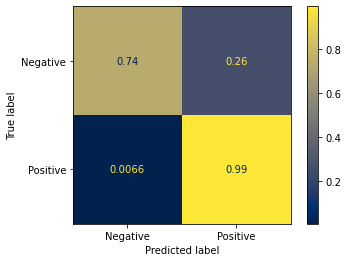

In [45]:
plot_confusion_matrix(mnb, X_t_vec, y_t, normalize='true', cmap='cividis', display_labels=['Negative', 'Positive']);

In [47]:
y_val_hat = mnb.predict(X_val_vec)
confusion_matrix(y_val, y_val_hat)

array([[ 13,  61],
       [ 11, 398]])

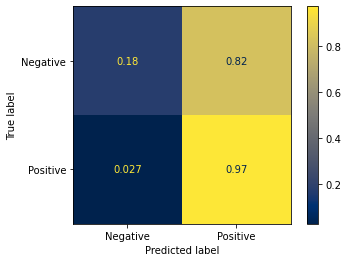

In [48]:
plot_confusion_matrix(mnb, X_val_vec, y_val, normalize='true', cmap='cividis', display_labels=['Negative', 'Positive'])

In [49]:
print(f'Accuracy for train set: {accuracy_score(y_t, y_t_hat)}') 
print(f'Accuracy for validation set: {accuracy_score(y_val, y_val_hat)}') 

Accuracy for train set: 0.9502762430939227
Accuracy for validation set: 0.8509316770186336


Predicting negative emotion is still a challenge. the high variance between the two sets is also concerning. 

Trying TF-IDF vectorizer to see if theres any improvement

In [50]:
tfidf = TfidfVectorizer()
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_val_vec = tfidf.transform(X_val)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
mnb2 = MultinomialNB()
mnb2.fit(X_t_vec, y_t)
y_t_hat2 = mnb2.predict(X_t_vec)
confusion_matrix(y_t, y_t_hat2)

array([[  27,  215],
       [   0, 1206]])